In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [21]:
token_latency = pd.read_csv(
    "iter_level/iter_result_token_latency_swap_multi_tokens_limit_less_prefill_seq_policy.csv"
)
base_batch_sizes = token_latency["batch_size"].unique()
token_latency = token_latency.drop(
    columns=[
        "prefill_token_num_each_request",
        "cvs",
        "enable_chunk_prefill",
        "prefill_mode",
        "policy",
        "strategy",
    ]
)

In [22]:
token_latency[
        (token_latency["current_stage"] == "prefill")
        & (token_latency["recomputed_token_nums"] == 0)
        & (token_latency["batch_size"]<=1024)
        & (token_latency["repeat_time"] > 0)
    ][["num_tokens", "latency", "batch_size", "max_token_num"]]

,num_tokens,latency,batch_size,max_token_num
161,6,0.025546,8,1024
322,6,0.025292,8,1024
483,6,0.026320,8,1024
644,6,0.026195,8,1024
805,6,0.024707,8,1024
...,...,...,...,...
22755,510,0.148578,512,2048
22976,510,0.150839,512,2048
23197,510,0.151423,512,2048
23418,510,0.249609,512,2048


/tmp/ipykernel_750903/3112607702.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: get_predicted_latency_coeff(df))
/tmp/ipykernel_750903/3112607702.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: get_predicted_latency_coeff(df))


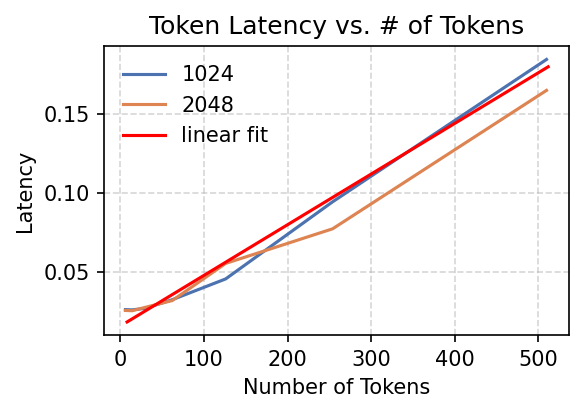

In [23]:
prefill_num_latency = (
    token_latency[
        (token_latency["current_stage"] == "prefill")
        & (token_latency["recomputed_token_nums"] == 0)
        & (token_latency["batch_size"] <= 1024)
        & (token_latency["repeat_time"] > 0)
    ][["num_tokens", "latency", "batch_size", "max_token_num"]]
    .groupby(["num_tokens", "batch_size", "max_token_num"])
    .mean()
    .reset_index()
)
decode_num_latency = (
    token_latency[
        (token_latency["current_stage"] == "decode")
        & (token_latency["recomputed_token_nums"] == 0)
        & (token_latency["batch_size"] <= 1024)
        & (token_latency["repeat_time"] > 0)
    ][["num_tokens", "latency", "batch_size", "max_token_num"]]
    .groupby(["num_tokens", "batch_size", "max_token_num"])
    .mean()
    .reset_index()
)


def get_predicted_latency_coeff(df):
    coeff = np.polyfit(df["batch_size"], df["latency"], deg=1)

    return coeff[0], coeff[1]


prefill_token_num_latency_coeffs = (
    prefill_num_latency.groupby("max_token_num")
    .apply(lambda df: get_predicted_latency_coeff(df))
    .apply(pd.Series)
    .T
)

decode_num_latency_coeffs = (
    decode_num_latency.groupby("max_token_num")
    .apply(lambda df: get_predicted_latency_coeff(df))
    .apply(pd.Series)
    .T
)


plt.figure(figsize=(4, 2.5), dpi=150)
sns.lineplot(
    x="num_tokens",
    y="latency",
    hue="max_token_num",
    data=prefill_num_latency,
    sort=True,
    palette="deep",
)


sns.lineplot(
    x=prefill_num_latency[prefill_num_latency["max_token_num"] == 1024][
        "batch_size"
    ],
    y=np.poly1d(prefill_token_num_latency_coeffs[1024].values)(
        prefill_num_latency[prefill_num_latency["max_token_num"] == 1024][
            "batch_size"
        ]
    ),
    color="red",
    label="linear fit",
)
token_nums = sorted(prefill_num_latency["batch_size"].unique())
# plt.yscale("log")
plt.legend(frameon=False)
plt.title("Token Latency vs. # of Tokens")

# plt.xticks(token_nums,rotation=90)
# plt.xlim(192, 2048)
plt.xlabel("Number of Tokens")
plt.ylabel("Latency")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

In [24]:
# prefill_coefficient = [0.00039137, 0.02193963]
# decode_coefficient = [0.00023192, 0.01490469]


def get_predicted_latency(row):
    decode_tokens = row["batch_size"] - 2
    prefill_tokens = row["num_tokens"] - decode_tokens
    prefill_coefficient = list(
        prefill_token_num_latency_coeffs[row["max_token_num"]].values
    )
    decode_coefficient = list(
        decode_num_latency_coeffs[row["max_token_num"]].values
    )
    prefill_latency = (
        prefill_coefficient[0] * prefill_tokens + prefill_coefficient[1]
    )
    decode_latency = (
        decode_coefficient[0] * decode_tokens + decode_coefficient[1]
    )
    return prefill_latency + decode_latency


prefill_num_latency["predicted_latency"] = prefill_num_latency.apply(
    get_predicted_latency, axis=1
)
prefill_num_latency["latency_diff"] = (
    prefill_num_latency["predicted_latency"] - prefill_num_latency["latency"]
)

In [40]:
token_latency[
    (token_latency["current_stage"] == "hybrid")
    & (token_latency["recomputed_token_nums"] == 0)
    # & (token_latency["request_num_each_round"] == token_latency["batch_size"])
    & (token_latency["num_tokens"] == token_latency["max_token_num"])
][["batch_size", "latency", "num_tokens", "max_token_num"]][
    "num_tokens"
].unique()

array([1024, 2048])

In [41]:
full_chunk_latency = (
    token_latency[
        (token_latency["current_stage"] == "hybrid")
        & (token_latency["recomputed_token_nums"] == 0)
        & (token_latency["num_tokens"] == token_latency["max_token_num"])
    ][["batch_size", "latency", "num_tokens", "max_token_num"]]
    .groupby(["batch_size", "num_tokens", "max_token_num"])
    .mean()
    .reset_index()
)
full_chunk_latency["throughput"] = (
    full_chunk_latency["num_tokens"] / full_chunk_latency["latency"]
)

In [42]:
pure_decode_latency = (
    token_latency[
        (token_latency["current_stage"] == "decode")
        & (token_latency["recomputed_token_nums"] == 0)
        & (
            token_latency["request_num_each_round"]
            == token_latency["batch_size"] - 2
        )
    ][["batch_size", "latency", "num_tokens", "max_token_num"]]
    .groupby(["batch_size", "num_tokens", "max_token_num"])
    .mean()
    .reset_index()
)
pure_decode_latency["throughput"] = (
    pure_decode_latency["num_tokens"] / pure_decode_latency["latency"]
)

In [43]:
chunk_latency_differ = full_chunk_latency.merge(
    pure_decode_latency, on=["batch_size", "max_token_num"], how="left"
)


def calculate_predicted_latency(row, base_batch_size, max_token_num):
    base_latency_x = chunk_latency_differ[
        (chunk_latency_differ["batch_size"] == base_batch_size)
        & (chunk_latency_differ["max_token_num"] == max_token_num)
    ]["latency_x"].values[0]
    base_latency_y = chunk_latency_differ[
        chunk_latency_differ["batch_size"] == base_batch_size
    ]["latency_y"].values[0]
    predicted_latency = base_latency_x + base_latency_y * max(
        (row["batch_size"] / base_batch_size - 2), 0
    )
    return predicted_latency


def calculate_predicted_latency_ratio(row, base_batch_size):
    predicted_latency = row[f"predicted_latency_{base_batch_size}"]
    latency_x = row["latency_x"]
    predicted_latency_ratio = (predicted_latency - latency_x) / latency_x * 100
    return predicted_latency_ratio


def calculate_throughput(row, base_batch_size):
    predicted_latency = row[f"predicted_latency_{base_batch_size}"]
    token_nums = row["num_tokens_x"]
    throughput = token_nums / predicted_latency
    return throughput


def calculate_predicted_throughput_ratio(row, base_batch_size):
    predicted_throughput = row[f"predicted_throughput_{base_batch_size}"]
    throughput_x = row["throughput_x"]
    predicted_throughput_ratio = (
        (predicted_throughput - throughput_x) / throughput_x * 100
    )
    return predicted_throughput_ratio


# Apply the functions to calculate the predicted latency and ratio for each batch size
for base_batch_size in base_batch_sizes:
    chunk_latency_differ[
        f"predicted_latency_{base_batch_size}"
    ] = chunk_latency_differ.apply(
        lambda row: calculate_predicted_latency(
            row, base_batch_size, row["max_token_num"]
        ),
        axis=1,
    )
    chunk_latency_differ[
        f"predicted_latency_{base_batch_size}_ratio"
    ] = chunk_latency_differ.apply(
        lambda row: calculate_predicted_latency_ratio(row, base_batch_size),
        axis=1,
    )
    chunk_latency_differ[
        f"predicted_throughput_{base_batch_size}"
    ] = chunk_latency_differ.apply(
        lambda row: calculate_throughput(row, base_batch_size),
        axis=1,
    )
    chunk_latency_differ[
        f"predicted_throughput_{base_batch_size}_ratio"
    ] = chunk_latency_differ.apply(
        lambda row: calculate_predicted_throughput_ratio(row, base_batch_size),
        axis=1,
    )


chunk_latency_differ["diff_prefill_decode"] = (
    chunk_latency_differ["latency_x"] - chunk_latency_differ["latency_y"]
)

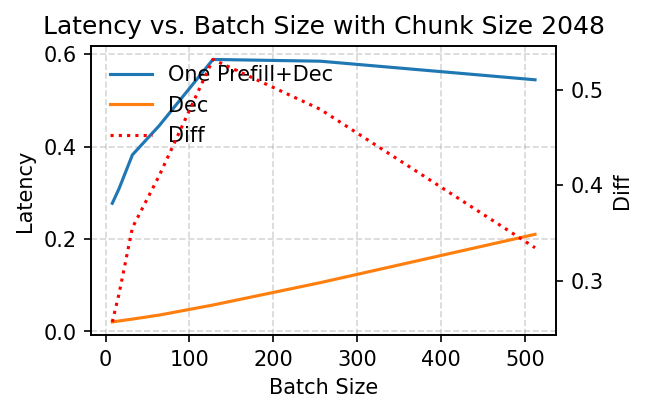

In [44]:
plt.figure(figsize=(4, 2.5), dpi=150)
ax = sns.lineplot(
    chunk_latency_differ[(chunk_latency_differ["max_token_num"] == 2048)],
    x="batch_size",
    y="latency_x",
    label="One Prefill+Dec",
    legend=False,
)

sns.lineplot(
    chunk_latency_differ[(chunk_latency_differ["max_token_num"] == 2048)],
    x="batch_size",
    y="latency_y",
    label="Dec",
    legend=False,
    ax=ax,
)
ax1 = ax.twinx()
sns.lineplot(
    data=chunk_latency_differ[(chunk_latency_differ["max_token_num"] == 2048)],
    x="batch_size",
    y="diff_prefill_decode",
    label="Diff",
    color="red",
    linestyle=":",
    ax=ax1,
    legend=False,
)
ax_legends = ax.get_legend_handles_labels()
ax1_legend = ax1.get_legend_handles_labels()
ax.legend(
    frameon=False,
    handles=ax_legends[0] + ax1_legend[0],
    labels=ax_legends[1] + ax1_legend[1],
    loc="upper left",
)


# ax.set_xticks(base_batch_sizes)
ax.set_xlabel("Batch Size")
ax.set_ylabel("Latency")
ax1.set_ylabel("Diff")
ax.set_title("Latency vs. Batch Size with Chunk Size 2048")
ax.grid(alpha=0.5, linestyle="--")
plt.show()

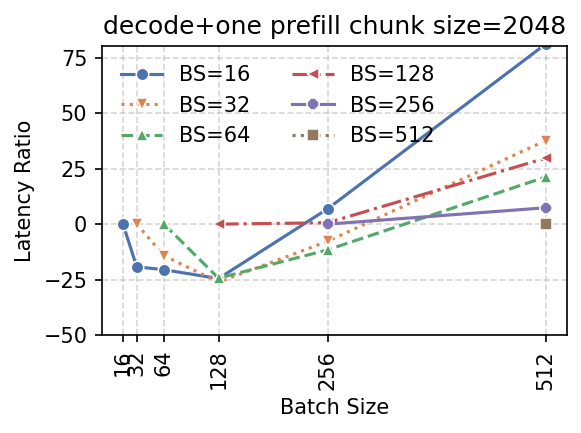

In [59]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
base_batch_sizes = [16, 32, 64, 128, 256, 512]
line_styles = ["-", ":", "--", "-."]
markers = ["o", "v", "^", "<", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"]
for token_nums in base_batch_sizes:
    sns.lineplot(
        chunk_latency_differ[
            (chunk_latency_differ["batch_size"] >= token_nums)
            & (chunk_latency_differ["max_token_num"] == 2048)
        ],
        x="batch_size",
        y=f"predicted_latency_{token_nums}_ratio",
        label=f"BS={token_nums}",
        legend=False,
        color=colors[base_batch_sizes.index(token_nums)],
        linestyle=line_styles[base_batch_sizes.index(token_nums) % 4],
        marker=markers[base_batch_sizes.index(token_nums)],
    )
plt.legend(frameon=False, ncol=2)
plt.xlabel("Batch Size")
plt.ylabel("Latency Ratio")
plt.ylim(-50, 80)
# plt.yscale("symlog")
# plt.yticks(np.arange(-20, 40, step=10))
plt.xticks(base_batch_sizes, rotation=90)
plt.title("decode+one prefill chunk size=2048")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

In [49]:
chunk_tp_differ = chunk_latency_differ.copy()
chunk_tp_differ["tp_x"] = (
    chunk_tp_differ["num_tokens_x"] / chunk_tp_differ["latency_x"]
)
chunk_tp_differ["tp_y"] = (
    chunk_tp_differ["num_tokens_y"] / chunk_tp_differ["latency_y"]
)

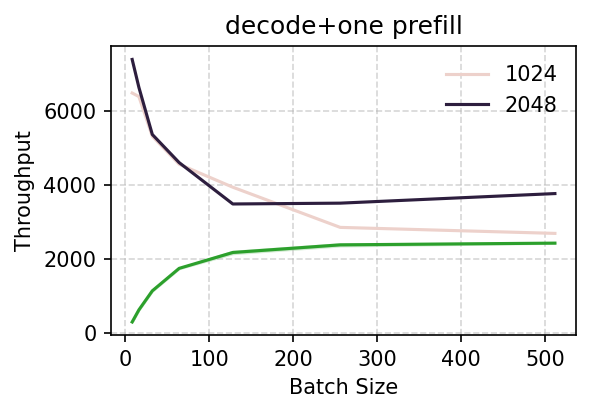

In [54]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
sns.lineplot(
    x="batch_size", y="tp_x",hue='max_token_num', data=chunk_tp_differ
)
sns.lineplot(x="batch_size", y="tp_y", data=chunk_tp_differ)
plt.legend(frameon=False, ncol=1)
plt.xlabel("Batch Size")
plt.ylabel("Throughput")
# plt.ylim(0,1.2
# plt.xticks(batch_sizes,rotation=90)
plt.title("decode+one prefill")
plt.grid(alpha=0.5, linestyle="--")
plt.show()

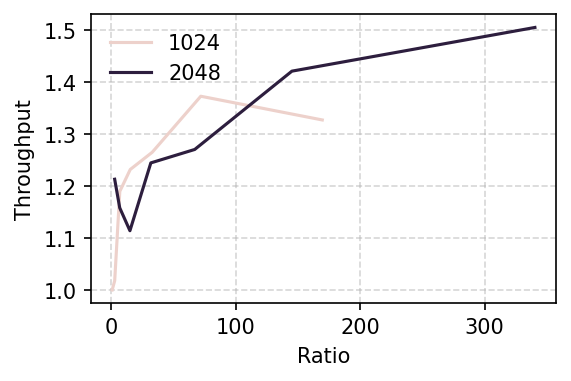

In [57]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
chunk_tp_differ["prefill_tokens"] = (
    chunk_tp_differ["num_tokens_x"] - chunk_tp_differ["batch_size"] + 2
)
chunk_tp_differ["decode_tokens"] = chunk_tp_differ["batch_size"] - 2
chunk_tp_differ["ratio"] = (
    chunk_tp_differ["prefill_tokens"] / chunk_tp_differ["decode_tokens"]
)
chunk_tp_differ["total_tp"] = chunk_tp_differ["tp_x"] + chunk_tp_differ["tp_y"]
chunk_tp_differ["normalized_tp"] = chunk_tp_differ["total_tp"] / (
    chunk_tp_differ["total_tp"].min()
)
sns.lineplot(
    x="ratio", y="normalized_tp", data=chunk_tp_differ, hue="max_token_num"
)
plt.legend(frameon=False, ncol=1)
plt.xlabel("Ratio")
plt.ylabel("Throughput")
# plt.ylim(0,1.2
# plt.xticks(batch_sizes,rotation=90)
plt.grid(alpha=0.5, linestyle="--")
plt.show()

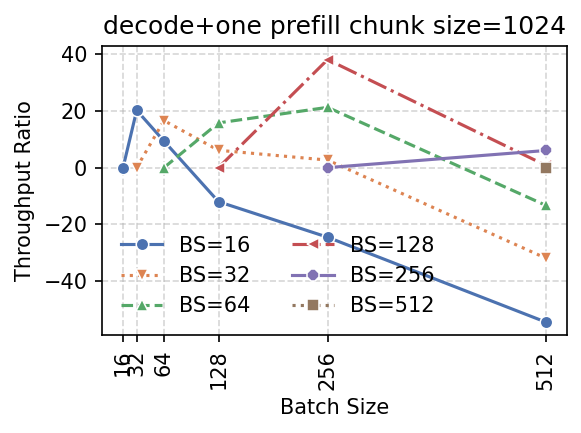

In [64]:
plt.figure(figsize=(4, 2.5), dpi=150)
colors = sns.color_palette("deep")
base_batch_sizes = [16, 32, 64, 128, 256, 512]
line_styles = ["-", ":", "--", "-."]
markers = ["o", "v", "^", "<", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X"]
for token_nums in base_batch_sizes:
    sns.lineplot(
        chunk_latency_differ[
            (chunk_latency_differ["batch_size"] >= token_nums)
            & (chunk_latency_differ["max_token_num"] == 1024)
        ],
        x="batch_size",
        y=f"predicted_throughput_{token_nums}_ratio",
        label=f"BS={token_nums}",
        legend=False,
        color=colors[base_batch_sizes.index(token_nums)],
        linestyle=line_styles[base_batch_sizes.index(token_nums) % 4],
        marker=markers[base_batch_sizes.index(token_nums)],
    )
plt.legend(frameon=False, ncol=2)
plt.xlabel("Batch Size")
plt.ylabel("Throughput Ratio")
# plt.ylim(-20,80)
# plt.yscale("symlog")
# plt.yticks(np.arange(-20, 40, step=10))
plt.xticks(base_batch_sizes, rotation=90)
plt.title("decode+one prefill chunk size=1024")
plt.grid(alpha=0.5, linestyle="--")
plt.show()